In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(desc="my bar!")

import time

/Users/d107520/venvs/mllib/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import chart_studio

chart_studio.tools.set_credentials_file(username='sreejith_citizens', api_key='QuqatPMwePJF2GdJL5SQ')

In [3]:
#data = pd.read_csv("2019_nCoV_data.csv")

# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="corona app")

# def get_lat_long(city):
#     time.sleep(10)
#     location = geolocator.geocode(city)
#     return (location.latitude, location.longitude)    

# data3['lat_long'] = data3.progress_apply(lambda x: get_lat_long(x["Province/State"]), axis=1)

__Load the geotagged data__

In [4]:
d1 = pd.read_csv("corona1.csv")
d2 = pd.read_csv("corona2.csv")
d3 = pd.read_csv("corona3.csv")
d4 = pd.read_csv("corona4.csv")

In [5]:
data = pd.concat([d1, d2, d3, d4])

In [6]:
del data["Unnamed: 0"]

In [7]:
data.head()

,Sno,Province/State,Country,Last Update,Confirmed,Deaths,Recovered,lat_long
0,1,Anhui,China,1/22/2020 12:00,1.0,0.0,0.0,"(32.0, 117.0)"
1,2,Beijing,China,1/22/2020 12:00,14.0,0.0,0.0,"(39.906217, 116.3912757)"
2,3,Chongqing,China,1/22/2020 12:00,6.0,0.0,0.0,"(30.05518, 107.8748712)"
3,4,Fujian,China,1/22/2020 12:00,1.0,0.0,0.0,"(26.5450001, 117.842778)"
4,5,Gansu,China,1/22/2020 12:00,0.0,0.0,0.0,"(38.0000001, 101.9999999)"


__Some preprocessing__

In [8]:
dc_latlong = "(38.8948932, -77.0365529)"
wash_latlong = "(47.7511, 120.7401)"
data.replace(to_replace=dc_latlong, value=wash_latlong,inplace=True)

In [9]:
# convert the string date to date
data["Last Update"] = pd.to_datetime(data['Last Update'])

In [10]:
df = data.groupby('Province/State')
df = pd.DataFrame(df['Last Update'].max()).reset_index()
last_update_data = df.merge(data, how='inner', on=['Province/State', 'Last Update'])

In [11]:
last_update_data.head()

,Province/State,Last Update,Sno,Country,Confirmed,Deaths,Recovered,lat_long
0,Anhui,2020-01-29 21:00:00,319,Mainland China,200.0,0.0,2.0,"(32.0, 117.0)"
1,Arizona,2020-01-29 21:00:00,351,US,1.0,0.0,0.0,"(34.395342, -111.7632755)"
2,Bavaria,2020-01-29 21:00:00,367,Germany,4.0,0.0,0.0,"(48.9467562, 11.4038717)"
3,Beijing,2020-01-29 21:00:00,325,Mainland China,111.0,1.0,4.0,"(39.906217, 116.3912757)"
4,British Columbia,2020-01-29 21:00:00,361,Canada,1.0,0.0,0.0,"(55.001251, -125.002441)"


In some cases the provinces are not available (or are NaNs). Let's filter them out

In [12]:
nan_province_data = data[data["Province/State"].isnull()]
len(nan_province_data)

66

In [13]:
nan_province_data.Country.unique()

array(['Japan', 'Thailand', 'South Korea', 'Singapore', 'Philippines',
       'Malaysia', 'Vietnam', 'Australia', 'Mexico', 'Brazil', 'France',
       'Nepal', 'Cambodia', 'Sri Lanka', 'Ivory Coast', 'Finland'],
      dtype=object)

__Filter these on a country level last date__

In [14]:
nandf = nan_province_data.groupby('Country')
nandf = pd.DataFrame(nandf['Last Update'].max()).reset_index()
nan_province_last_update_data = nandf.merge(nan_province_data, how='inner', on=['Country', 'Last Update'])

Lets append this with the *last_update_data*  

In [15]:
filtered_data = pd.concat([last_update_data, nan_province_last_update_data])

/Users/d107520/venvs/mllib/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [16]:
filtered_data

,Confirmed,Country,Deaths,Last Update,Province/State,Recovered,Sno,lat_long
0,200.0,Mainland China,0.0,2020-01-29 21:00:00,Anhui,2.0,319,"(32.0, 117.0)"
1,1.0,US,0.0,2020-01-29 21:00:00,Arizona,0.0,351,"(34.395342, -111.7632755)"
2,4.0,Germany,0.0,2020-01-29 21:00:00,Bavaria,0.0,367,"(48.9467562, 11.4038717)"
3,111.0,Mainland China,1.0,2020-01-29 21:00:00,Beijing,4.0,325,"(39.906217, 116.3912757)"
4,1.0,Canada,0.0,2020-01-29 21:00:00,British Columbia,0.0,361,"(55.001251, -125.002441)"
...,...,...,...,...,...,...,...,...
11,10.0,Singapore,0.0,2020-01-29 21:00:00,NaN,0.0,355,"(46.3144754, 11.0480288)"
12,4.0,South Korea,0.0,2020-01-29 21:00:00,NaN,0.0,354,"(46.3144754, 11.0480288)"
13,1.0,Sri Lanka,0.0,2020-01-29 21:00:00,NaN,0.0,363,"(46.3144754, 11.0480288)"
14,14.0,Thailand,0.0,2020-01-29 21:00:00,NaN,5.0,353,"(46.3144754, 11.0480288)"


__Heatmap of reports__

In [17]:
from ast import literal_eval

filtered_data["co_ord"] = filtered_data['lat_long'].apply(lambda x: literal_eval(x))

def make_heatmap_data(x, y):
    return (x[0], x[1], y)

filtered_data["heatmap_data"] = filtered_data.apply(lambda x: \
                                                          make_heatmap_data(x['co_ord'], x['Confirmed']), axis=1)

In [18]:
import folium
from folium.plugins import HeatMap

start = [30.5,20.30]

m = folium.Map(width=950,height=700, location=start, zoom_start=1.5, tiles='Stamen Toner')

locations = filtered_data["heatmap_data"]
HeatMap(locations).add_to(m)

m

In [19]:
df_copy = data
df_copy["co_ord"] = df_copy['lat_long'].apply(lambda x: literal_eval(x))

df_copy['lat'] = data['co_ord'].apply(lambda x: x[0])
df_copy['long'] = data['co_ord'].apply(lambda x: x[1])

In [20]:
df_copy.head()

,Sno,Province/State,Country,Last Update,Confirmed,Deaths,Recovered,lat_long,co_ord,lat,long
0,1,Anhui,China,2020-01-22 12:00:00,1.0,0.0,0.0,"(32.0, 117.0)","(32.0, 117.0)",32.000000,117.000000
1,2,Beijing,China,2020-01-22 12:00:00,14.0,0.0,0.0,"(39.906217, 116.3912757)","(39.906217, 116.3912757)",39.906217,116.391276
2,3,Chongqing,China,2020-01-22 12:00:00,6.0,0.0,0.0,"(30.05518, 107.8748712)","(30.05518, 107.8748712)",30.055180,107.874871
3,4,Fujian,China,2020-01-22 12:00:00,1.0,0.0,0.0,"(26.5450001, 117.842778)","(26.5450001, 117.842778)",26.545000,117.842778
4,5,Gansu,China,2020-01-22 12:00:00,0.0,0.0,0.0,"(38.0000001, 101.9999999)","(38.0000001, 101.9999999)",38.000000,102.000000


In [21]:
df_copy["date"] = df_copy['Last Update'].dt.strftime("%m/%d/%Y, %H:%M:%S")

In [22]:
df_copy['Last Update'].sort_values().unique()

array(['2020-01-22T12:00:00.000000000', '2020-01-23T12:00:00.000000000',
       '2020-01-24T12:00:00.000000000', '2020-01-25T12:00:00.000000000',
       '2020-01-25T22:00:00.000000000', '2020-01-26T23:00:00.000000000',
       '2020-01-27T20:30:00.000000000', '2020-01-28T18:00:00.000000000',
       '2020-01-28T23:00:00.000000000', '2020-01-29T21:00:00.000000000'],
      dtype='datetime64[ns]')

In [23]:
import numpy as np
places = np.unique(df_copy[['lat','long']], axis=0)
places = [(x,y) for [x,y] in places]

case_dict = {}

In [24]:
df_day_list = []

weight_key = 'Confirmed'

for idx, date in enumerate(df_copy['Last Update'].sort_values().unique()):
    
    tmp = df_copy[df_copy['Last Update'] == date]
    tmp = tmp[['lat', 'long', weight_key]]
    total_confirmed = tmp.Confirmed.sum()
    tmp['weight'] = tmp['Confirmed'].apply(lambda x: x/total_confirmed)
    grp = tmp.groupby(['lat', 'long'])[weight_key].sum().reset_index()
    
    for index, row in grp.iterrows():
        case_dict[(row['lat'],row['long'])] = row[weight_key]
        
    update = []
    for key, val in case_dict.items():
        update.append([key[0], key[1], val])
        
    df_day_list.append(update)

In [25]:
index = df_copy['date'].sort_values().unique()

In [26]:
import folium.plugins as plugins

start = [30.5,20.30]
m = folium.Map(start, tiles='stamentoner', zoom_start=1.5)
hm = plugins.HeatMapWithTime(df_day_list, index=index.tolist(), auto_play=True, radius=8, scale_radius=False)
hm.add_to(m)

m

__Number of Cases reported on a country level__

In [28]:
#Find the last date for which data is available at a location

In [29]:
filtered_data.Country.unique()

array(['Mainland China', 'US', 'Germany', 'Canada', 'Hong Kong', 'Macau',
       'Australia', 'Taiwan', 'Brazil', 'Cambodia', 'Finland', 'France',
       'Ivory Coast', 'Japan', 'Malaysia', 'Mexico', 'Nepal',
       'Philippines', 'Singapore', 'South Korea', 'Sri Lanka', 'Thailand',
       'Vietnam'], dtype=object)

In [30]:
countries_spread = filtered_data.groupby("Country")["Confirmed"].sum().reset_index(name="case count")

In [31]:
countries_spread.sort_values(by="case count", ascending=False, inplace=True)

In [32]:
_data = [go.Bar(
            x=countries_spread["Country"],
            y=countries_spread["case count"]
    )]



layout = go.Layout(
    title='Case Count by country',
    
    xaxis=dict(
        title='Country',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Case Count',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=_data, layout=layout)
py.iplot(fig, filename='price')

__Deaths on a country level__

In [33]:
deaths_grouped = filtered_data.groupby("Country")["Deaths"].sum().reset_index(name="Deaths")
deaths_grouped.sort_values(by="Deaths", ascending=False, inplace=True)

df = countries_spread.merge(deaths_grouped, how="left", on="Country")

In [34]:
# Lets remove China since it makes the charts very tailed

df_ = df[df.Country != "Mainland China"]

In [35]:
df_.sort_values(by="case count", ascending=False, inplace=True)

/Users/d107520/venvs/mllib/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



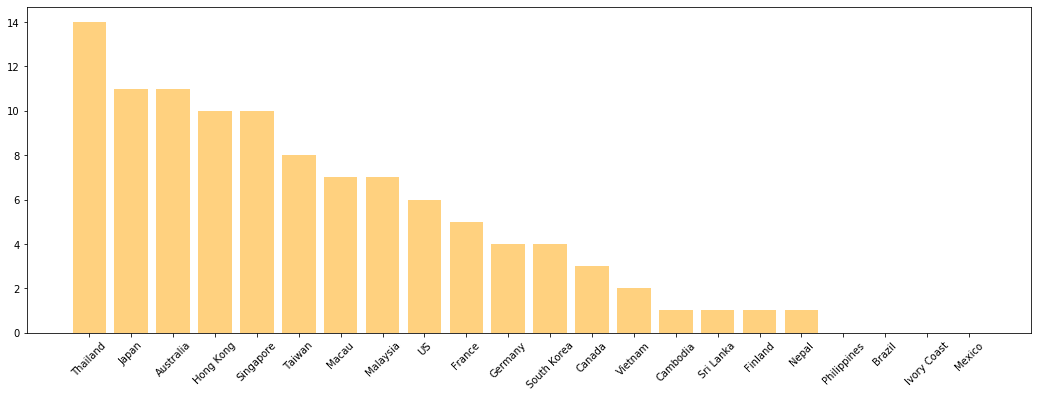

In [36]:
f1 = plt.figure(figsize=(18,6))

ax1 = f1.add_subplot(111)
ax1.bar(df_["Country"], df_["case count"], alpha=0.5, color="Orange")
ax1.bar(df_["Country"], df_["Deaths"], alpha=0.6, color="Red")

ax1.set_xticks(range(0,len(df_)))
ax1.set_xticklabels(df_["Country"], rotation=45)
plt.show()

__Number of reports in a time series in China (Growth Rate)__

In [37]:
china_data = data[(data.Country == 'China') | 
                  (data.Country == 'Mainland China')]

In [38]:
china_data['date'] = china_data['Last Update'].dt.date

/Users/d107520/venvs/mllib/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Grouping on a day level and counting

In [39]:
china_data_grouped = pd.DataFrame(china_data.groupby("date")["Confirmed"].sum().reset_index(name="Count"))

In [40]:
# Confirmed cases overall
data['date'] = data['Last Update'].dt.date
data_grouped_by_date = pd.DataFrame(data.groupby("date")["Confirmed"].sum().reset_index(name="Count"))

In [41]:
f1 = plt.figure(figsize=(18,6))

# ax1 = f1.add_subplot(111)
# ax1.plot(china_data_grouped["date"], 
#         china_data_grouped["Count"], color="Red")
# ax1.plot(data_grouped_by_date["date"], 
#         data_grouped_by_date["Count"], color="Blue")
# ax1.set_title("Confirmed case count in China")
# plt.show()



_data = [go.Line(
            x=china_data_grouped["date"],
            y=china_data_grouped["Count"],
            name="China"
    ), go.Line(
            x=data_grouped_by_date["date"],
            y=data_grouped_by_date["Count"], 
            name="World")]



layout = go.Layout(
    title='Confirmed case count in China/Overall',
    
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Case Count Growth',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=_data, layout=layout)
py.iplot(fig, filename='date_grouped')

/Users/d107520/venvs/mllib/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<Figure size 1296x432 with 0 Axes>